# Project Part 2: Data Cleaning and Analysis

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, auc, roc_curve
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None  # default='warn'

In [51]:
#! pip install kds # once this is installed, comment out for time
import kds

## 2.1 Merge files

In [52]:
week1 = pd.read_csv('week1_wBlitz.csv')
week2 = pd.read_csv('week2_wBlitz.csv')
week3 = pd.read_csv('week3_wBlitz.csv')
week4 = pd.read_csv('week4_wBlitz.csv')
week5 = pd.read_csv('week5_wBlitz.csv')
week6 = pd.read_csv('week6_wBlitz.csv')
week7 = pd.read_csv('week7_wBlitz.csv')
week8 = pd.read_csv('week8_wBlitz.csv')

In [53]:
all_weeks = pd.concat([week1, week2, week3, week4, week5, week6, week7, week8], ignore_index=True)

## 2.2 Data Cleaning

### Drop unecessary columns

In [54]:
all_weeks.drop(['Unnamed: 0', 'gameId', 'playId', 'foulName1','foulNFLId1', 'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3', 'yardlineSide'], axis=1, inplace=True)

A blitz is decided prior to the play. Columns that refer to actions that occur as a result of the play are dropped. 

In [55]:
all_weeks.drop(['playDescription', 'playResult', 'prePenaltyPlayResult', 'penaltyYards', 'passResult'], axis=1, inplace=True)

In [56]:
# odd row with nan, drop it
all_weeks.dropna(inplace=True)

### `gameClock` adjustments

The columne `gameClock` is originally a string. This is converted to `secondsRemaining` and is the seconds remaining in this quarter. 

In [57]:
all_weeks[['min', 'sec']] = all_weeks.gameClock.str.split(":", expand = True)

In [58]:
all_weeks['min'] = all_weeks['min'].astype(int)
all_weeks['sec'] = all_weeks['sec'].astype(int)

In [59]:
all_weeks['secondsRemaining'] = all_weeks['min']*60 + all_weeks['sec']

In [60]:
# drop original columns
all_weeks.drop(['gameClock','min','sec'], axis=1, inplace=True)

In [61]:
all_weeks.head()

,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineNumber,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,numBackfield,isBlitz,weekNum,secondsRemaining
0,1,3,2,TB,DAL,33,0,0,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,5,1,1,813
1,1,1,10,DAL,TB,2,0,0,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,5,1,1,798
2,1,2,6,DAL,TB,34,0,0,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,4,0,1,743
3,1,1,10,DAL,TB,39,0,0,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,5,1,1,596
4,1,3,15,DAL,TB,44,0,0,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,5,1,1,586


### Modify personnel. 

Offensive personnel, in the column `PersonnelO` sometimes includes athletes outside of running backs, tight ends, and wid receivers. This may be due to the source of the information, which is often different individuals working for Pro Football Focus or from anomalies that occur (ex. another QB must sub in for an RB). 

Offensive players: RB, TE, WR

Defensive players: DL, LB, DB

In [62]:
all_weeks.personnelO = all_weeks.personnelO.astype('str')

In [63]:
# this could be a function, but I could not get a good version to work, so doing it by hand for now....
all_weeks.personnelO.replace('6 OL, 1 RB, 1 TE, 2 WR', '1 RB, 1 TE, 2 WR', inplace=True)
all_weeks.personnelO.replace('6 OL, 1 RB, 2 TE, 1 WR', '1 RB, 2 TE, 1 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 1 RB, 1 TE, 2 WR', '1 RB, 1 TE, 2 WR', inplace=True)
all_weeks.personnelO.replace('6 OL, 2 RB, 2 TE, 0 WR', '2 RB, 2 TE, 0 WR', inplace=True)
all_weeks.personnelO.replace('6 OL, 1 RB, 3 TE, 0 WR', '1 RB, 3 TE, 0 WR', inplace=True)
all_weeks.personnelO.replace('6 OL, 2 RB, 0 TE, 2 WR', '2 RB, 0 TE, 2 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 1 RB, 0 TE, 3 WR', '1 RB, 0 TE, 3 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 1 RB, 2 TE, 1 WR', '1 RB, 2 TE, 1 WR', inplace=True)
all_weeks.personnelO.replace('6 OL, 2 RB, 1 TE, 1 WR', '2 RB, 1 TE, 1 WR', inplace=True)
all_weeks.personnelO.replace('1 RB, 1 TE, 2 WR,1 LB', '1 RB, 1 TE, 2 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 2 RB, 0 TE, 2 WR', '2 RB, 0 TE, 2 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 6 OL, 1 RB, 1 TE, 1 WR', '1 RB, 1 TE, 1 WR', inplace=True)
all_weeks.personnelO.replace('6 OL, 1 RB, 0 TE, 3 WR', '1 RB, 0 TE, 3 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 2 RB, 1 TE, 1 WR', '2 RB, 1 TE, 1 WR', inplace=True)
all_weeks.personnelO.replace('2 QB, 1 RB, 3 TE, 0 WR', '1 RB, 3 TE, 0 WR', inplace=True)
all_weeks.personnelO.replace('7 OL, 1 RB, 0 TE, 2 WR', '1 RB, 0 TE, 2 WR', inplace=True)

# remove whitespace
all_weeks.personnelO.replace(' ', '', inplace=True)

## 2.3 Exploratory Data Analysis and Feature Importances

There are significant amount of categorical variables in this dataset. An exploratory data analysis will be used to 1) understand the dataset and 2) reduce categories of certain variables. 

Note: offenseFormation, dropBackType, pff_passCoverageType do not have a significant amount of variables (<10), so they are not evaluated. 

In [64]:
# get a list of the current categorical variables
all_weeks.select_dtypes(include=['object', 'string']).columns.tolist()

['possessionTeam',
 'defensiveTeam',
 'offenseFormation',
 'personnelO',
 'personnelD',
 'dropBackType',
 'pff_passCoverage',
 'pff_passCoverageType']

### Evaluate possessionTeam
This variable represents the team that has control of the ball. This evaluation of feature importances seeks to answer the question: Do blitzes occur at a different rate when a certain team has the ball?

In [65]:
df_to_collapse = all_weeks[['possessionTeam', 'isBlitz']]
# change the variable to object
df_to_collapse['possessionTeam'] = df_to_collapse['possessionTeam'].astype('O')
# dummy-encode
df_to_collapse = pd.get_dummies(df_to_collapse, drop_first = True)
df_to_collapse.head()

# run random forest
rf = RandomForestClassifier()
rf.fit(df_to_collapse.drop('isBlitz', axis = 1), df_to_collapse['isBlitz'])

feature_importances = pd.DataFrame({'Variable' :df_to_collapse.drop('isBlitz', axis = 1).columns, 'Importance': rf.feature_importances_})
feature_importances.set_index('Variable', inplace = True)
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
#feature_importances

For clarity, view feature importances in a bar chart. 

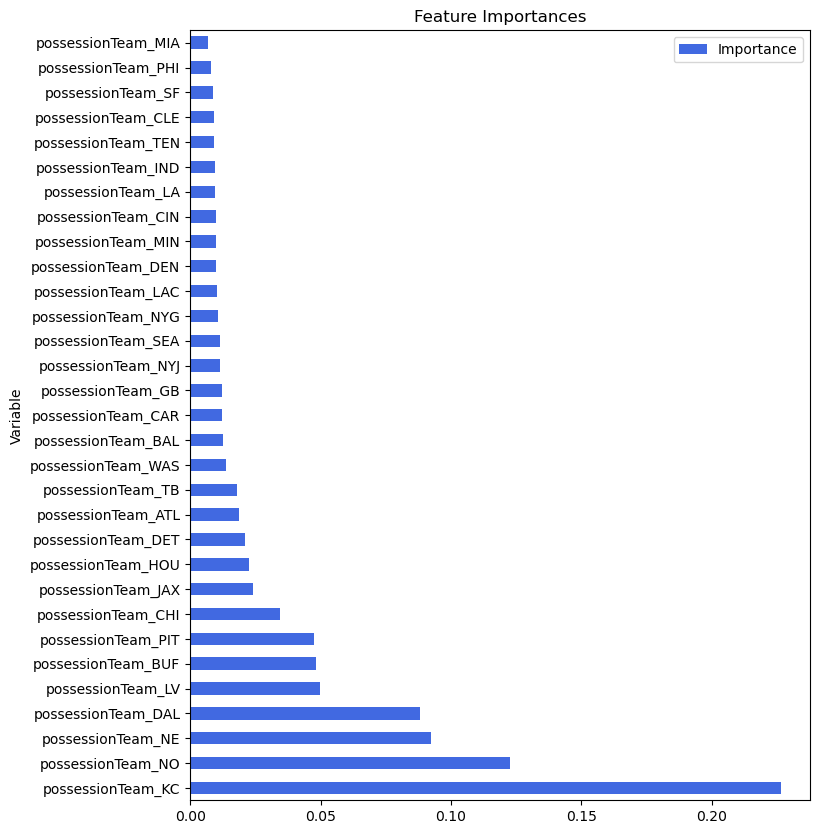

In [66]:
import matplotlib.pyplot as plt
feature_importances.plot(kind = 'barh', color = 'royalblue', figsize = (8,10))
plt.title('Feature Importances')
plt.show()

Based on the bar chart, it appears that when possessionTeam_KC (Kansas City Chiefs) possess the ball, blitzes occur. 

There is a significant gap between KC and the next team. Visually, it appears that the top four teams induce the most blitzes. 
Because this analysis seeks to evaluate the situation rather than the propensity of a team to incur a blitz, all categories are kept here. 

### Evaluate defensiveTeam

In [67]:
df_to_collapse = all_weeks[['defensiveTeam', 'isBlitz']]
# change the variable to object
df_to_collapse['defensiveTeam'] = df_to_collapse['defensiveTeam'].astype('O')
# dummy-encode
df_to_collapse = pd.get_dummies(df_to_collapse, drop_first = True)
df_to_collapse.head()

# run random forest
rf = RandomForestClassifier()
rf.fit(df_to_collapse.drop('isBlitz', axis = 1), df_to_collapse['isBlitz'])

feature_importances = pd.DataFrame({'Variable' :df_to_collapse.drop('isBlitz', axis = 1).columns, 'Importance': rf.feature_importances_})
feature_importances.set_index('Variable', inplace = True)
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
#feature_importances

For clarity, view feature importances in a bar chart. 

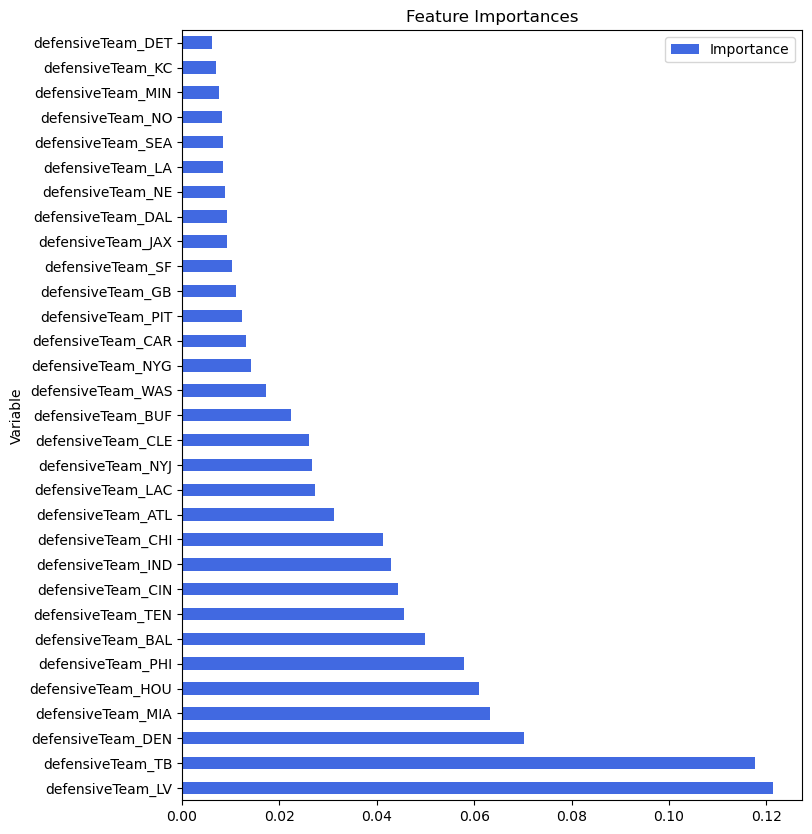

In [68]:
import matplotlib.pyplot as plt
feature_importances.plot(kind = 'barh', color = 'royalblue', figsize = (8,10))
plt.title('Feature Importances')
plt.show()

This provides significant exploratory power. It appears the defensiveTeam_LV (Las Vegas Raiders) and defensiveTeam_TB (Tampa Bay Buccaneers) perform the blitzes to a greater extent. Again, no features removed. 

### Evaluate personnelO, offensive personnel

In [69]:
df_to_collapse = all_weeks[['personnelO', 'isBlitz']]
# change the variable to object
df_to_collapse['personnelO'] = df_to_collapse['personnelO'].astype('O')
# dummy-encode
df_to_collapse = pd.get_dummies(df_to_collapse, drop_first = True)
df_to_collapse.head()

# run random forest
rf = RandomForestClassifier()
rf.fit(df_to_collapse.drop('isBlitz', axis = 1), df_to_collapse['isBlitz'])

feature_importances = pd.DataFrame({'Variable' :df_to_collapse.drop('isBlitz', axis = 1).columns, 'Importance': rf.feature_importances_})
feature_importances.set_index('Variable', inplace = True)
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
#feature_importances

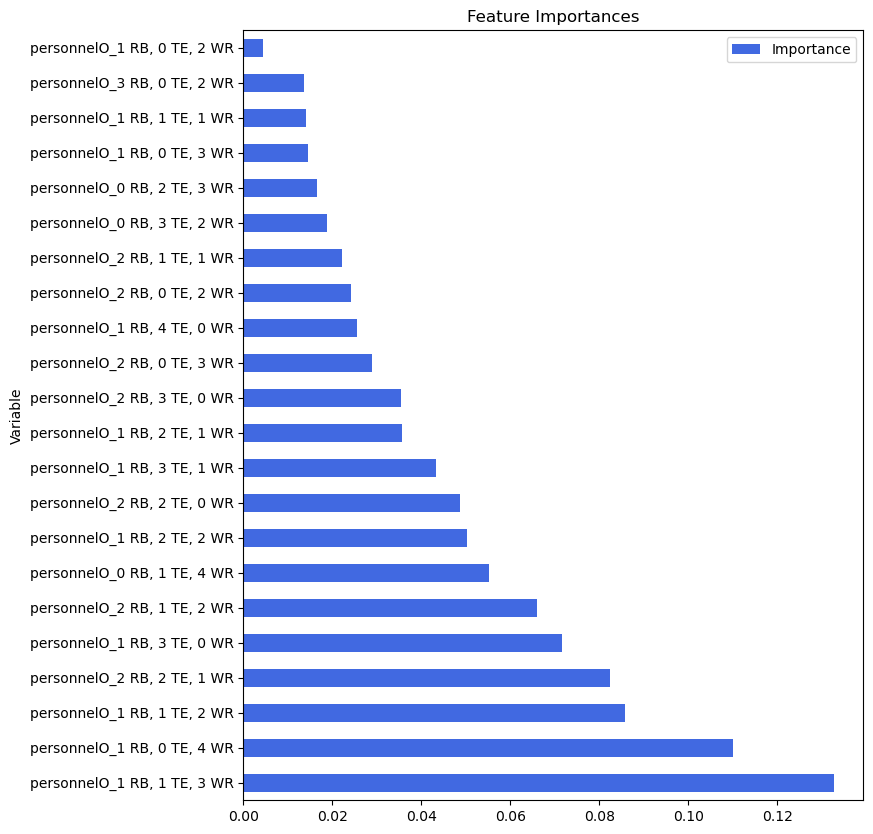

In [70]:
import matplotlib.pyplot as plt
feature_importances.plot(kind = 'barh', color = 'royalblue', figsize = (8,10))
plt.title('Feature Importances')
plt.show()

Two categories of offensive personnel appear to stand out above the rest. These two cagegories (personnelO_1 RB, 0 TE, 4 WR and personnelO_1 RB, 1 TE, 3 WR) are kept. 

In [71]:
all_weeks['personnelO_1 RB, 1 TE, 3 WR'] = (all_weeks["personnelO"] == '1 RB, 1 TE, 4 WR').astype('int')
all_weeks['personnelO_1 RB, 0 TE, 4 WR'] = (all_weeks["personnelO"] == '1 RB, 1 TE, 4 WR').astype('int')

all_weeks.drop('personnelO', axis=1, inplace=True)

### Evaluate personnelD, defensive personnel

In [72]:
df_to_collapse = all_weeks[['personnelD', 'isBlitz']]
# change the variable to object
df_to_collapse['personnelD'] = df_to_collapse['personnelD'].astype('O')
# dummy-encode
df_to_collapse = pd.get_dummies(df_to_collapse, drop_first = True)
df_to_collapse.head()

# run random forest
rf = RandomForestClassifier()
rf.fit(df_to_collapse.drop('isBlitz', axis = 1), df_to_collapse['isBlitz'])

feature_importances = pd.DataFrame({'Variable' :df_to_collapse.drop('isBlitz', axis = 1).columns, 'Importance': rf.feature_importances_})
feature_importances.set_index('Variable', inplace = True)
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
#feature_importances

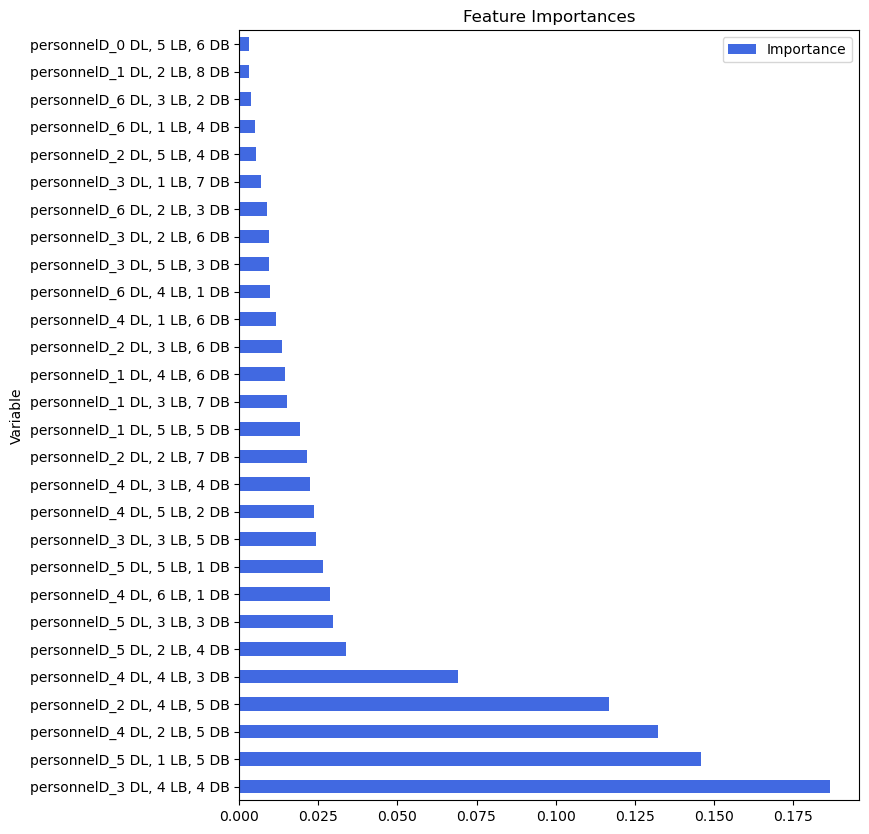

In [73]:
import matplotlib.pyplot as plt
feature_importances.plot(kind = 'barh', color = 'royalblue', figsize = (8,10))
plt.title('Feature Importances')
plt.show()

This bar chart shows 5 clear defensive personnel formations that are associated with a blitz. Those are kept in favor of all personnel formations that appear in this dataset.

In [74]:
all_weeks['personnelD_4 DL, 4 LB, 5 DB'] = (all_weeks["personnelD"] == '4 DL, 4 LB, 5 DB').astype('int')
all_weeks['personnelD_2 DL, 4 LB, 5 DB'] = (all_weeks["personnelD"] == '2 DL, 4 LB, 5 DB').astype('int')
all_weeks['personnelD_4 DL, 2 LB, 5 DB'] = (all_weeks["personnelD"] == '4 DL, 2 LB, 5 DB').astype('int')
all_weeks['personnelD_5 DL, 1 LB, 5 DB'] = (all_weeks["personnelD"] == '5 DL, 1 LB, 5 DB').astype('int')
all_weeks['personnelD_3 DL, 4 LB, 4 DB'] = (all_weeks["personnelD"] == '3 DL, 4 LB, 4 DB').astype('int')

all_weeks.drop('personnelD', axis=1, inplace=True)

### Evaluate pff_passCoverage

In [75]:
df_to_collapse = all_weeks[['pff_passCoverage', 'isBlitz']]
# change the variable to object
df_to_collapse['pff_passCoverage'] = df_to_collapse['pff_passCoverage'].astype('O')
# dummy-encode
df_to_collapse = pd.get_dummies(df_to_collapse, drop_first = True)
df_to_collapse.head()

# run random forest
rf = RandomForestClassifier()
rf.fit(df_to_collapse.drop('isBlitz', axis = 1), df_to_collapse['isBlitz'])

feature_importances = pd.DataFrame({'Variable' :df_to_collapse.drop('isBlitz', axis = 1).columns, 'Importance': rf.feature_importances_})
feature_importances.set_index('Variable', inplace = True)
feature_importances = feature_importances.sort_values(by = 'Importance', ascending = False)
#feature_importances

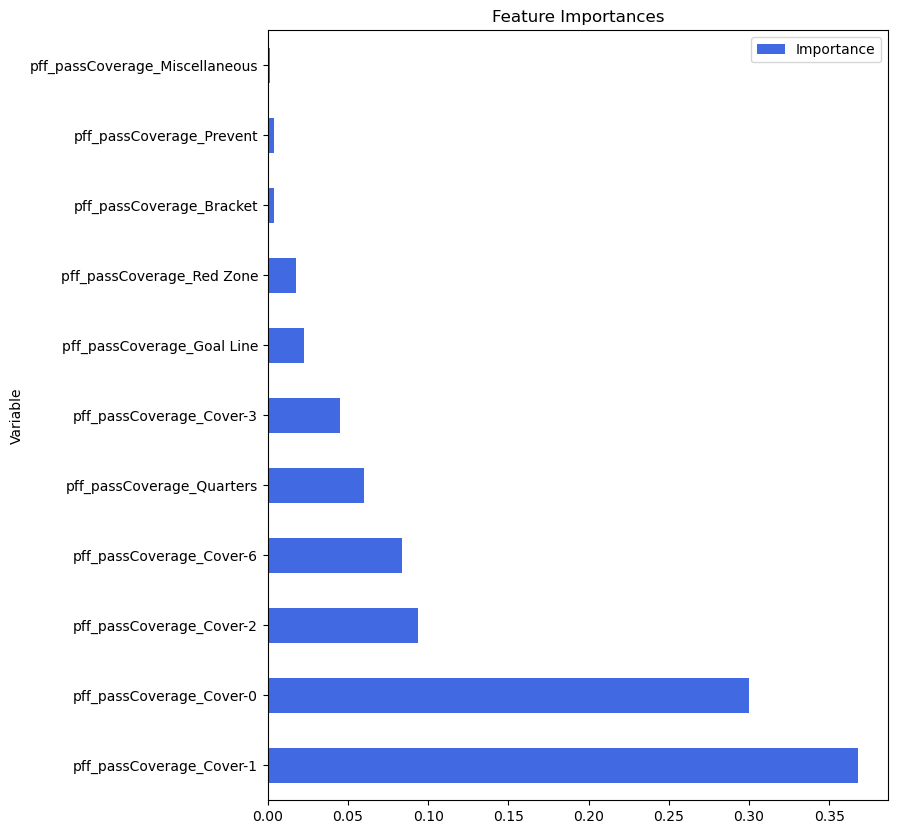

In [76]:
import matplotlib.pyplot as plt
feature_importances.plot(kind = 'barh', color = 'royalblue', figsize = (8,10))
plt.title('Feature Importances')
plt.show()

This bar chart suggests that Cover-0 and Cover-1 are most associated with a blitz. This follows with what is understood about indicators of a blitz. Keep these. 

In [77]:
all_weeks['pff_passCoverage_Cover-0'] = (all_weeks["pff_passCoverage"] == 'Cover-0').astype('int')
all_weeks['pff_passCoverage_Cover-1'] = (all_weeks["pff_passCoverage"] == 'Cover-1').astype('int')

all_weeks.drop('pff_passCoverage', axis=1, inplace=True)

## 2.4 Data Analysis

### Analysis Setup

In [78]:
df = all_weeks   # save an original version of the df

In [79]:
df.head()

,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineNumber,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,offenseFormation,defendersInBox,dropBackType,pff_playAction,pff_passCoverageType,numBackfield,isBlitz,weekNum,secondsRemaining,"personnelO_1 RB, 1 TE, 3 WR","personnelO_1 RB, 0 TE, 4 WR","personnelD_4 DL, 4 LB, 5 DB","personnelD_2 DL, 4 LB, 5 DB","personnelD_4 DL, 2 LB, 5 DB","personnelD_5 DL, 1 LB, 5 DB","personnelD_3 DL, 4 LB, 4 DB",pff_passCoverage_Cover-0,pff_passCoverage_Cover-1
0,1,3,2,TB,DAL,33,0,0,43.0,SHOTGUN,6.0,TRADITIONAL,0,Man,5,1,1,813,0,0,0,0,1,0,0,0,1
1,1,1,10,DAL,TB,2,0,0,108.0,EMPTY,6.0,TRADITIONAL,0,Zone,5,1,1,798,0,0,0,0,0,0,0,0,0
2,1,2,6,DAL,TB,34,0,0,76.0,SHOTGUN,6.0,TRADITIONAL,0,Zone,4,0,1,743,0,0,0,0,0,0,0,0,0
3,1,1,10,DAL,TB,39,0,0,49.0,SINGLEBACK,6.0,TRADITIONAL,1,Zone,5,1,1,596,0,0,0,0,0,0,0,0,0
4,1,3,15,DAL,TB,44,0,0,54.0,SHOTGUN,7.0,TRADITIONAL,0,Zone,5,1,1,586,0,0,0,0,0,0,1,0,0


For categorical variables, use dummy encoding. 

In [80]:
df = pd.get_dummies(df, drop_first = True, columns = ['possessionTeam','defensiveTeam', 'offenseFormation','dropBackType', 'pff_passCoverageType'])



### Check correlation

In [81]:
corr = df.corr() # creates a df of correlation 

Consider a threshold of 75% to be considered "too corrrelated." Then, print the indices where too much correlation occurs. 

In [82]:
threshold = 0.75

[(i, j) for i,j in zip(*np.where(np.abs(corr.values) > threshold)) if i!=j]

[(9, 10), (10, 9), (21, 98), (98, 21)]

In [83]:
df.iloc[1:2,98]

1    1
Name: pff_passCoverageType_Zone, dtype: uint8

Based on the indices above, the following variables are considered too correlated:

1. numBackfield and isBlitz. This suggests that the number of players in the backfield is closely associated to a Blitz. Eliminate this numBackfield from variables. 
    
2. pff_passCoverage_Cover-1 and pff_passCoverageType_Zone. This makes sense from defensive strategy. However, Zone accounts for more plays than Cover-1 (is more general), so Zone is kept in favor of Cover-1. 
    

In [84]:
df.drop(['numBackfield', 'pff_passCoverage_Cover-1'], axis=1, inplace=True)        


### Scale, then split into training and test data. 

In [85]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X = df.drop('isBlitz', axis=1)

X_scale = scaler.fit_transform(X)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scale, df['isBlitz'], test_size = 0.3, random_state = 1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5621, 96) (5621,)
(2409, 96) (2409,)


### Logistic Regression: Lasso

In [87]:
lasso_reg = LogisticRegression(
    penalty='l1',   # LASSO --> do only a few predictors impact response?
    C=1,
    solver='liblinear')

lasso_reg.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [88]:
score = round((lasso_reg.score(X_test, y_test) * 100),2)
print(f'Accuracy is {score}% for Lasso.')

y_pred = lasso_reg.predict(X_test) 
cm = confusion_matrix(y_test,y_pred)
cm

Accuracy is 75.43% for Lasso.


array([[1545,  149],
       [ 443,  272]])

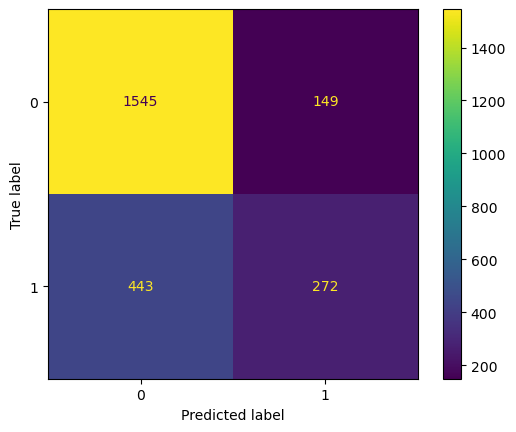

In [89]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

### Logistic Regression: Ridge

In [90]:
ridge_reg = LogisticRegression(
    penalty='l2',   # RIDGE --> do most predictors impact response?
    C=1,
    solver='liblinear')

ridge_reg.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [91]:
score = round((ridge_reg.score(X_test, y_test)*100),2)
print(f'Accuracy is {score}% for Ridge.')

Accuracy is 75.43% for Ridge.


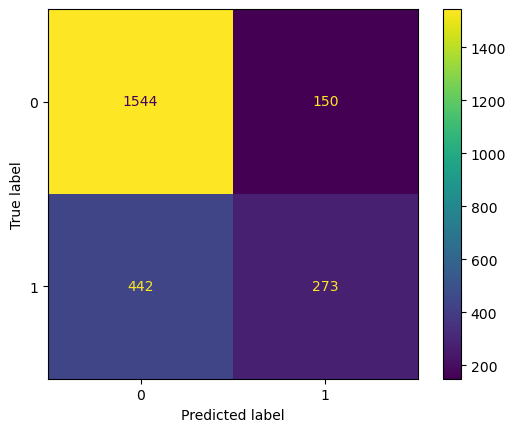

In [92]:
y_pred_r = ridge_reg.predict(X_test) 
cm_r = confusion_matrix(y_test,y_pred_r)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_r)
disp.plot()
plt.show()

### Bagging Ensemble

In [96]:
grid = {'n_estimators': [20, 21, 22, 25, 35], 
        'max_samples':[490, 500, 510, 515, 550], 
        'max_features':[20, 21, 25, 30, 35, 40, 42, 45, 50]}

In [97]:
bag = GridSearchCV(BaggingClassifier(), grid, cv=5, n_jobs=-1)
bag.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(), n_jobs=-1,
             param_grid={'max_features': [20, 21, 25, 30, 35, 40, 42, 45, 50],
                         'max_samples': [490, 500, 510, 515, 550],
                         'n_estimators': [20, 21, 22, 25, 35]})

In [ ]:
# check best parameters
bps = bag.best_params_
# check estimated accuracy
acc = round((bag.best_score_)*100,2)
print(f'The estimated accuracy of bagging is {acc}%')
print(f'The best parameters that correspond with this accuracy are {bps}')

In [ ]:
print(classification_report(y_test, bag.predict(X_test)))

### Random Forest

In [98]:
# NOTE: GridSearch was used, and the below uncommented values had the best accuracy. 
grid = { 'criterion':['gini'], # 'entropy'], 
        'max_depth':[25],#[15, 20, 25, 30], 
        'min_samples_split':[50], #[40, 45, 50, 75, 100],
       'n_estimators': [210]#[190, 200, 210, 250]
       }

In [99]:
rf = GridSearchCV(RandomForestClassifier(), grid, cv=5, n_jobs=-1)
rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [25],
                         'min_samples_split': [50], 'n_estimators': [210]})

In [100]:
# check best parameters
bps = rf.best_params_ 
# check estimated accuracy
acc = round((rf.best_score_)*100,2)
print(f'The estimated accuracy of random forest is {acc}%')
print(f'The best parameters that correspond with this accuracy are {bps}')

The estimated accuracy of random forest is 76.52%
The best parameters that correspond with this accuracy are {'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 50, 'n_estimators': 210}


In [101]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85      1694
           1       0.75      0.27      0.40       715

    accuracy                           0.76      2409
   macro avg       0.75      0.62      0.62      2409
weighted avg       0.75      0.76      0.71      2409



## Compare all models

### Area under the curve
In this section, area under the curve is evaluated for each model. 

In [ ]:
#Logistic Regression - Lasso
fpr, tpr, thresh = roc_curve(y_test, lasso_reg.predict_proba(X_test)[:,1])
auc(fpr, tpr)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label= f'ROC curve (area = {auc(fpr, tpr): 0.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC Curve Test Data LogReg, Lasso')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#Logistic Regression - Ridge
fpr, tpr, thresh = roc_curve(y_test, ridge_reg.predict_proba(X_test)[:,1])
auc(fpr, tpr)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label= f'ROC curve (area = {auc(fpr, tpr): 0.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC Curve Test Data LogReg, Ridge')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Bagging
fpr, tpr, thresh = roc_curve(y_test, bag.predict_proba(X_test)[:,1])
auc(fpr, tpr)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label= f'ROC curve (area = {auc(fpr, tpr): 0.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC Curve Test Data Bagging')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()

In [ ]:
#Random Forest
fpr, tpr, thresh = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
auc(fpr, tpr)

In [ ]:
plt.figure(figsize = (8,6))
plt.plot(fpr, tpr, label= f'ROC curve (area = {auc(fpr, tpr): 0.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
plt.title('ROC Curve Test Data Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.legend()
plt.show()

### Lift

In [ ]:
# Logistic Regression - Lasso
kds.metrics.report(y_test, lasso_reg.predict_proba(X_test)[:,1])

In [ ]:
# Logistic Regression - Ridge
kds.metrics.report(y_test, ridge_reg.predict_proba(X_test)[:,1])

In [ ]:
# Bagging Ensemble
kds.metrics.report(y_test, bag.predict_proba(X_test)[:,1])

In [ ]:
# Random Forest
kds.metrics.report(y_test, rf.predict_proba(X_test)[:,1])

# Comparing All Models

| Model Name | Accuracy | Recall| AUC | Lift Top 10% |
| :---: | --|--|--|:--:|
| Logistic Regression, Lasso | 75.43 % | 77.74 % | 0.76 | 2.42 |
| Logistic Regression, Ridge | 75.43 % | 77.74 % | 0.76 | 2.42 | 2.08 | 
| Bagging Ensemble | 75.29 % | 19.00 % | 0.69 | 2.28 | 
| Random Forest | 76.66 % | 26.00 % | 0.77 | 2.50 |

The Random Forest model is selected as the best. Please see associated paper for further discussion. Feature importances of this model is evaluated below. 

In [144]:
feature_names = df.drop('isBlitz', axis=1).columns

In [145]:
importances = rf.best_estimator_.feature_importances_

In [146]:
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

In [147]:
forest_importances

pff_passCoverageType_Zone              0.162068
defendersInBox                         0.068083
pff_passCoverage_Cover-0               0.063794
yardsToGo                              0.054857
secondsRemaining                       0.048669
yardlineNumber                         0.046129
absoluteYardlineNumber                 0.045141
down                                   0.040297
preSnapVisitorScore                    0.028236
preSnapHomeScore                       0.027480
weekNum                                0.022158
pff_passCoverageType_Other             0.016165
offenseFormation_SHOTGUN               0.012875
quarter                                0.012806
personnelD_5 DL, 1 LB, 5 DB            0.012605
personnelD_3 DL, 4 LB, 4 DB            0.011310
personnelD_4 DL, 2 LB, 5 DB            0.009881
possessionTeam_DAL                     0.008394
defensiveTeam_DEN                      0.008343
defensiveTeam_LA                       0.008102
dropBackType_TRADITIONAL               0